# Error propagration with taking into account of correlations b/w parameters

In other notebook, we showed that, for higher redshifts, errorbars in SFRD are pretty large; could this be due to correlation among parameters -- meaning the Schechter function parameters, $M_*$, $\phi_*$ and $\alpha$ are not independent of each other. Previously we considered them as independent Gaussian variables. Now, we would like to take in account of this correlations. We, however, first treat them as Gaussian independent variables and see what we could get, i.e., we check how well we can constrain SFRD.

In the following notebook, we use data from [Bouwens+15](https://ui.adsabs.harvard.edu/abs/2015ApJ...803...34B/abstract).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as con
import os
import corner
import utils as utl
import posdef as pdf
from tqdm import tqdm
import scipy.integrate as inte

In [2]:
# Redshift
z_bou = np.array([4,5,6,7,8])

# Characteristic absolute magnitude
mst_bou = np.array([-20.88, -21.17, -20.94, -20.87, -20.63])
msterr_bou = np.array([0.08, 0.12, 0.2, 0.26, 0.36])

# Characteristic luminosity
lst_bou = np.array([])
lsterr_bou = np.array([])

for i in range(len(mst_bou)):
    mst1 = np.random.normal(mst_bou[i], msterr_bou[i], 10000)
    lst1 = utl.m_to_l_wave(mst1, 1500)
    lst_bou = np.hstack((lst_bou, np.mean(lst1)))
    lsterr_bou = np.hstack((lsterr_bou, np.std(lst1)))

# Alpha
alp_bou = np.array([-1.64, -1.76, -1.87, -2.06, -2.02])
alperr_bou = np.array([0.04, 0.05, 0.1, 0.13, 0.23])

# Normalisation constant
phi_bou = np.array([1.97, 0.74, 0.50, 0.29, 0.21])*0.001
phi_pos_err_bou = np.array([0.34, 0.18, 0.22, 0.21, 0.23])*0.001
phi_neg_err_bou = np.array([0.29, 0.14, 0.16, 0.12, 0.11])*0.001
phi_avg_err_bou = (phi_pos_err_bou + phi_neg_err_bou)/2

# Kappas
sol_lum = (con.L_sun*1e7).value
kap_uv = 2.2e-10/sol_lum
kap_ir = 4.5*10**(-44)

# Range of Luminosities (or absolute magnitudes) used
mags_bou = np.linspace(-24, -13, 1000)
lums_bou = utl.m_to_l_wave(mags_bou, 1500)

#print(np.log10(lst_bou))
#print(np.log10(lsterr_bou))
#print(np.log10(lums_bou))

In [3]:
sfrd_bou = np.array([])
sfrd_err_bou = np.array([])

z_bou1 = np.array([z_bou[2]])

for i in range(len(z_bou)):
    sfr1, sfr_e1 = utl.sfrd_w_err(lum=lums_bou, lum1=lst_bou[i], lum1err=lsterr_bou[i], phi1=phi_bou[i], phi1err=phi_avg_err_bou[i], alpha=alp_bou[i], alphaerr=alperr_bou[i], kappa=kap_uv)
    if sfr1 != 0:
        sfrd_bou = np.hstack((sfrd_bou, sfr1))
        sfrd_err_bou = np.hstack((sfrd_err_bou, sfr_e1))

  0%|          | 9/10000 [00:00<01:54, 87.28it/s]
length: 
10000
  0%|          | 9/10000 [00:00<01:54, 87.53it/s]
length: 
10000
  0%|          | 7/10000 [00:00<02:28, 67.51it/s]
length: 
10000
  0%|          | 6/10000 [00:00<02:57, 56.33it/s]
length: 
10000
100%|██████████| 10000/10000 [02:30<00:00, 66.38it/s]
length: 
9990



In [4]:
log_sfrd_bou = np.array([])
log_sfrd_bou_err = np.array([])

for i in range(len(sfrd_bou)):
    par, err = utl.log_err(sfrd_bou[i], sfrd_err_bou[i])
    log_sfrd_bou = np.hstack((log_sfrd_bou, par))
    log_sfrd_bou_err = np.hstack((log_sfrd_bou_err, err))

print('Values of SFRD (in M_sun/year): ')
for i in range(len(sfrd_bou)):
    print('For redshift {:d}: {:f} +/- {:f}'.format(z_bou[i], sfrd_bou[i], sfrd_err_bou[i]))
print('--------------------------------')
print('Values of SFRD (in log M_sun/year): ')
for i in range(len(log_sfrd_bou)):
    print('For redshift {:d}: {:f} +/- {:f}'.format(z_bou[i], log_sfrd_bou[i], log_sfrd_bou_err[i]))

Values of SFRD (in M_sun/year): 
For redshift 4: 0.037579 +/- 0.007147
For redshift 5: 0.021844 +/- 0.005797
For redshift 6: 0.014641 +/- 0.007246
For redshift 7: 0.011387 +/- 0.008587
For redshift 8: 0.007066 +/- 0.009085
--------------------------------
Values of SFRD (in log M_sun/year): 
For redshift 4: -1.425051 +/- 0.082597
For redshift 5: -1.660667 +/- 0.115255
For redshift 6: -1.834415 +/- 0.214922
For redshift 7: -1.943585 +/- 0.327492
For redshift 8: -2.150857 +/- 0.558403


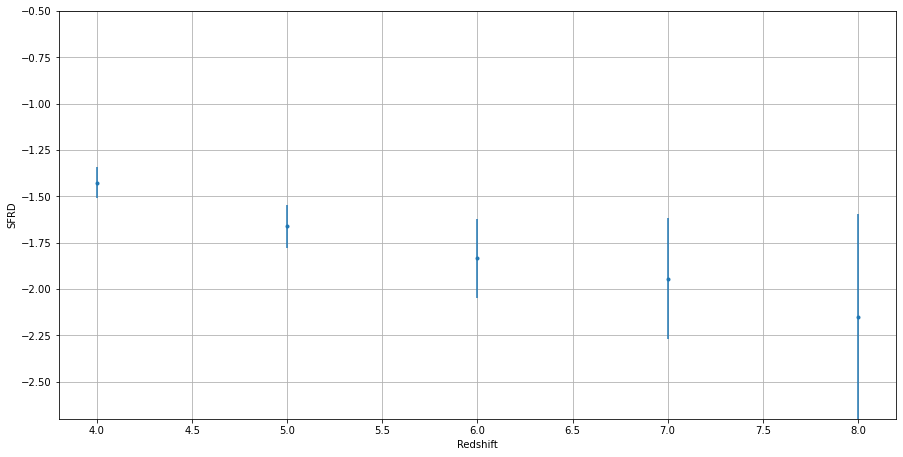

In [5]:
plt.figure(figsize=(15,7.5))
plt.errorbar(z_bou, log_sfrd_bou, yerr=log_sfrd_bou_err, fmt='.')
plt.xlabel('Redshift')
plt.ylabel('SFRD')
plt.ylim([-2.7, -0.5])
plt.grid()

## Using asymmetric distributions

Till now, we have been using a symmetric Gaussian distribution generated from `numpy.random.normal` module to sample the distribution of various parameters. However, that is not the case always -- often, especially for the parameter $\phi_*$, the errorbars are not exactly symmetric. Hence, we want to sample asymetric distributions for those parameters. We wrote a special function to do so in `util.py` script, namely `asymmetric_gausian_distribution` -- we would implement the same function to compute the luminosity density below,

In [6]:
def lum_den22(lum, lum1, lum1err, phi1, phi1errp, phi1errn, alpha, alphaerr, limit=0.03):
    """
    Function to calculate luminosity density
    ----------------------------------------
    Parameters:
    -----------
    lum : float, numpy.ndarray
        luminosity range
    phi1 : float
        normalisation constant
    phi1errp : float
        Positive error in normalisation constant
    phi1errn : float
        Negative error in normalisation constant
    lum1 : float
        characteristic luminosity
        the 'knee' of the function
    lum1err : float
        Error in characteristic luminosity
    alpha : float
        the faint-end slope of power law
    alphaerr : float
        Error in the faint-end slope of power law
    limit : float
        lower limit of the intensity
        as a function of L*
        default is 0.03 (from Madau&Dickinson)s
    -----------
    return
    -----------
    numpy.ndarray :
        an array of luminosity density
    """
    # Values of Parameters
    log_phi1, log_phip = utl.log_err(phi1, phi1errp)
    log_phi1, log_phin = utl.log_err(phi1, phi1errn)
    log_phi2 = utl.asymmetric_gausian_distribution(log_phi1, log_phip, log_phin, 10000)
    phi23 = 10**log_phi2
    if len(phi23) > 10000:
        lum2 = np.random.normal(lum1, lum1err, 10000)
        alp2 = np.random.normal(alpha, alphaerr, 10000)
        phi2 = np.random.choice(phi23, size=10000, replace=False)
    else:
        lum23 = np.random.normal(lum1, lum1err, 10000)
        alp23 = np.random.normal(alpha, alphaerr, 10000)
        lum2 = np.random.choice(lum23, size=len(phi23), replace=False)
        alp2 = np.random.choice(alp23, size=len(phi23), replace=False)
        phi2 = np.copy(phi23)
    # Values of luminosities
    nor_lum = np.linspace(limit*lum1, np.max(lum), 100000)
    # Integration array
    rho2 = np.array([])
    # Integration starts
    for i in tqdm(range(len(phi2))):
        if lum2[i] < 0 :#alp2[i] != alp2[i] or lum2[i] != lum2[i] or lum2[i] == 0 or phi2[i] != phi2[i]:
            continue
        else:
            nor_sc1 = utl.schechter(nor_lum, lum1=lum2[i], phi1=phi2[i], alpha=alp2[i])
            nor_sc = nor_lum*nor_sc1#/phi2[j]
            rho_nor = inte.simps(nor_sc, nor_lum)
            rho2 = np.hstack((rho2, rho_nor))
    print("\nlength: ")
    print(len(rho2))
    return rho2


def sfrd_w_err(lum, lum1, lum1err, phi1, phi1errp, phi1errn, alpha, alphaerr, kappa, limit=0.03):
    """
    Function to calculate luminosity density
    ----------------------------------------
    Parameters:
    -----------
    lum : float, numpy.ndarray
        luminosity range
    phi1 : float
        normalisation constant
    phi1errp : float
        Positive error in normalisation constant
    phi1errn : float
        Negative error in normalisation constant
    lum1 : float
        characteristic luminosity
        the 'knee' of the function
    lum1err : float
        Error in characteristic luminosity
    alpha : float
        the faint-end slope of power law
    alphaerr : float
        Error in the faint-end slope of power law
    kappa : float
        conversion factor b/w luminosity density and
        star formation rate
    limit : float
        lower limit of the intensity
        as a function of L*
        default is 0.03 (from Madau&Dickinson)
    -----------
    return
    -----------
    float
        mean star formation rate
    float
        error in star formation rate
    """
    lum_den2 = lum_den22(lum, lum1, lum1err, phi1, phi1errp, phi1errn, alpha, alphaerr, limit)
    kpp1 = kappa
    sfr2 = kpp1*lum_den2
    return np.mean(sfr2), np.std(sfr2)

In [7]:
sfrd_bou_asy = np.array([])
sfrd_err_bou_asy = np.array([])

for i in range(len(z_bou)):
    sfr1, sfr_e1 = sfrd_w_err(lum=lums_bou, lum1=lst_bou[i], lum1err=lsterr_bou[i], phi1=phi_bou[i], phi1errp=phi_pos_err_bou[i], phi1errn=phi_neg_err_bou[i], alpha=alp_bou[i], alphaerr=alperr_bou[i], kappa=kap_uv)
    if sfr1 != 0:
        sfrd_bou_asy = np.hstack((sfrd_bou_asy, sfr1))
        sfrd_err_bou_asy = np.hstack((sfrd_err_bou_asy, sfr_e1))

  0%|          | 0/10000 [00:00<?, ?it/s]
length: 
9930
  0%|          | 0/9917 [00:00<?, ?it/s]
length: 
10000
100%|██████████| 9917/9917 [01:49<00:00, 90.78it/s]

length: 
9917
100%|██████████| 9960/9960 [01:50<00:00, 90.16it/s]

length: 
9960
100%|██████████| 9996/9996 [01:57<00:00, 85.30it/s]
length: 
9981



In [8]:
log_sfrd_bou_asy = np.array([])
log_sfrd_bou_err_asy = np.array([])

for i in range(len(sfrd_bou_asy)):
    par, err = utl.log_err(sfrd_bou_asy[i], sfrd_err_bou_asy[i])
    log_sfrd_bou_asy = np.hstack((log_sfrd_bou_asy, par))
    log_sfrd_bou_err_asy = np.hstack((log_sfrd_bou_err_asy, err))

print('Values of SFRD (in M_sun/year): ')
for i in range(len(sfrd_bou_asy)):
    print('For redshift {:d}: {:f} +/- {:f}'.format(z_bou[i], sfrd_bou_asy[i], sfrd_err_bou_asy[i]))
print('--------------------------------')
print('Values of SFRD (in log M_sun/year): ')
for i in range(len(log_sfrd_bou)):
    print('For redshift {:d}: {:f} +/- {:f}'.format(z_bou[i], log_sfrd_bou_asy[i], log_sfrd_bou_err_asy[i]))

Values of SFRD (in M_sun/year): 
For redshift 4: 0.038439 +/- 0.007356
For redshift 5: 0.022900 +/- 0.006304
For redshift 6: 0.016467 +/- 0.008560
For redshift 7: 0.015361 +/- 0.013672
For redshift 8: 0.013579 +/- 0.026156
--------------------------------
Values of SFRD (in log M_sun/year): 
For redshift 4: -1.415232 +/- 0.083107
For redshift 5: -1.640166 +/- 0.119547
For redshift 6: -1.783389 +/- 0.225767
For redshift 7: -1.813592 +/- 0.386559
For redshift 8: -1.867136 +/- 0.836536


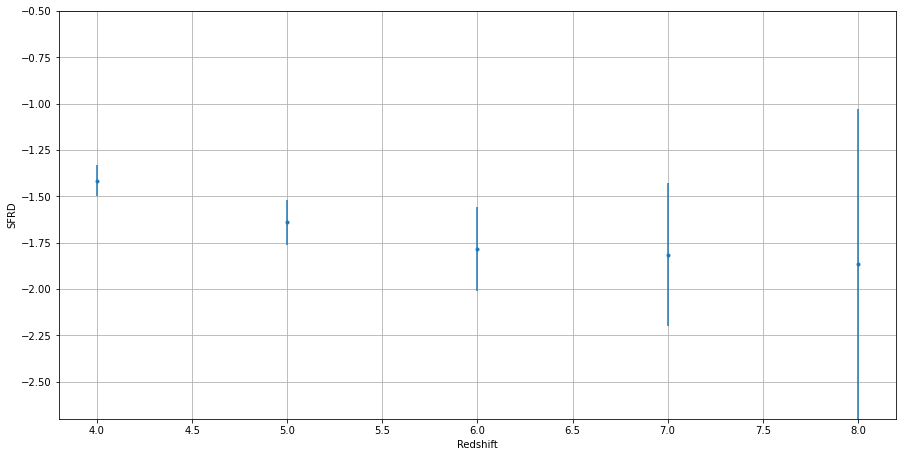

In [9]:
plt.figure(figsize=(15,7.5))
plt.errorbar(z_bou, log_sfrd_bou_asy, yerr=log_sfrd_bou_err_asy, fmt='.')
plt.xlabel('Redshift')
plt.ylabel('SFRD')
plt.ylim([-2.7, -0.5])
plt.grid()